In [1]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import math
import scienceplots
import matplotlib as mpl
from tqdm import tqdm
import optuna


In [3]:
device = torch.device('cpu')

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device) 
y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2+1) + 0.12*torch.randn(x.size()).to(device)  # 这里是污染数据固定不变当成训练数据


# Define network
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()

# 自定义训练过程
def objective(trial):
    noise = trial.suggest_float('noise', 0.01, 0.3)
    net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
    loss_func = torch.nn.MSELoss().to(device)
    NJnum = 10
    epoch = 15000
    train_losses = []
    
    for num in range(NJnum):
        seed = random.sample(range(1, 1000), 1)[0]#选择一个随机种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        net.reset_parameters()#每次实验前重置网络参数

        for _ in range(epoch):
            net.train()# 设定网络为训练模式
            prediction = net(x)
            loss = loss_func(prediction, y)
            optimizer.zero_grad()
            loss.backward()
            # 为梯度添加噪声
            with torch.no_grad():
                 for param in net.parameters():
                     param.grad += noise * torch.randn(param.grad.shape).to(param.grad.device)
            optimizer.step()
            
        train_losses.append(loss.item()) # 记录本次训练的损失值
        
    train_loss = np.mean(train_losses) # 计算平均训练损失
    
    # Test phase
    seeds = random.sample(range(1, 1000), 10)
    test_losses = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
        y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device)

        net.eval()# 设定网络为评估模式
        with torch.no_grad():
            prediction_test = net(x_test)
            test_loss = loss_func(prediction_test, y_test)
            test_losses.append(test_loss.item())

    mean_test_loss = np.mean(test_losses)

    return mean_test_loss

# Run optimization
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Use TPE sampler with seed
    pruner=optuna.pruners.MedianPruner()  # Use median pruner for early stopping
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

best_sigma = study.best_params["noise"]

[I 2024-07-06 23:46:57,530] A new study created in memory with name: no-name-d260071e-700b-4c63-a286-3ab3b636ef65


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-07-06 23:48:44,024] Trial 0 finished with value: 0.0237422414124012 and parameters: {'noise': 0.06554064060987876}. Best is trial 0 with value: 0.0237422414124012.
[I 2024-07-06 23:50:43,130] Trial 1 finished with value: 0.038241653330624105 and parameters: {'noise': 0.19041154360155124}. Best is trial 0 with value: 0.0237422414124012.
[I 2024-07-06 23:52:44,381] Trial 2 finished with value: 0.032187442481517795 and parameters: {'noise': 0.1369410443120632}. Best is trial 0 with value: 0.0237422414124012.
[I 2024-07-06 23:54:43,946] Trial 3 finished with value: 0.03636577464640141 and parameters: {'noise': 0.23775398927699307}. Best is trial 0 with value: 0.0237422414124012.
[I 2024-07-06 23:56:37,613] Trial 4 finished with value: 0.037757210247218606 and parameters: {'noise': 0.23619298435445302}. Best is trial 0 with value: 0.0237422414124012.
[I 2024-07-06 23:58:40,888] Trial 5 finished with value: 0.035704443231225014 and parameters: {'noise': 0.08905185553196605}. Best is 

In [4]:
best_noise = study.best_params["noise"]
print(best_noise)

0.010855220449407156


Best hyperparameter (sigma): 0.010855220449407156
Mean Test Loss: 0.02475537471473217
Mean Train Loss: 0.0047712731175124645


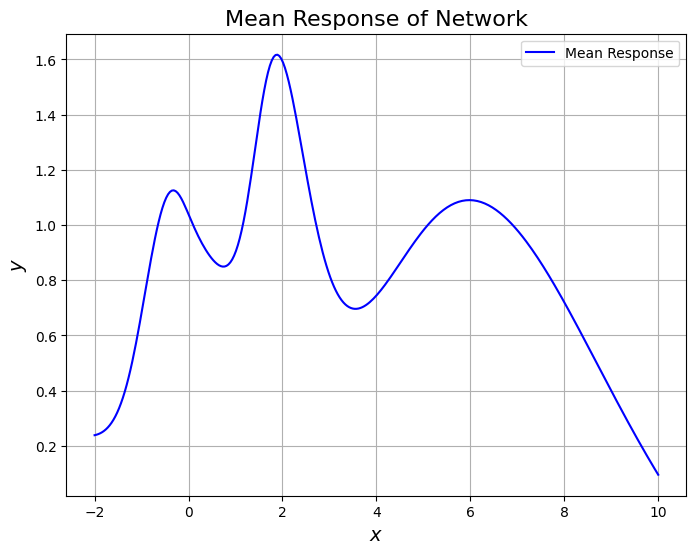

In [5]:
# 使用最佳参数重新训练模型
net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
loss_func = torch.nn.MSELoss().to(device)
# Define training settings
NJnum = 10
epoch = 15000

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())
# Define x_respond for response plotting
x_respond = torch.unsqueeze(torch.linspace(-2, 10, 300), dim=1)

# Initialize lists to store losses and responses
train_losses = []
responses = []

# Training loop with noisy data
for num in range(NJnum):
    seed = random.sample(range(1, 10000), 1)[0]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    net.reset_parameters()
    for t in range(epoch):
        net.train()
        prediction = net(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        # 为梯度添加噪声
        with torch.no_grad():
             for param in net.parameters():
                 param.grad += best_noise * torch.randn(param.grad.shape).to(param.grad.device)
            
        optimizer.step()
        
    # Append the train loss
    train_losses.append(loss.item())
    
    # Calculate mean response for x_respond after training
    net.eval()
    with torch.no_grad():
        response = net(x_respond)
        responses.append(response.numpy())
        
# Calculate mean train loss
mean_train_loss = np.mean(train_losses)
# Calculate mean response across NJnum runs
mean_response = np.mean(responses, axis=0)

# Test phase
seeds = random.sample(range(1, 10000), 10)
test_losses = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
    y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device) 


    net.eval()
    with torch.no_grad():
        prediction_test = net(x_test)
        test_loss = loss_func(prediction_test, y_test)
        test_losses.append(test_loss.item())

mean_test_loss = np.mean(test_losses)

print("Best hyperparameter (sigma):", best_noise)
print("Mean Test Loss:", mean_test_loss)
print("Mean Train Loss:", mean_train_loss)

# Plotting responses
plt.figure(figsize=(8, 6))
plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.title('Mean Response of Network', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()


In [6]:
# 将 x_respond 和 mean_response 保存到 CSV 文件
x_respond_np = x_respond.numpy()
output_data = np.hstack((x_respond_np, mean_response))
np.savetxt('D:/PycharmProjects/保存的参数/FOrestes（梯度）mean_response.csv', output_data, delimiter=',', header='x,mean_response', comments='')


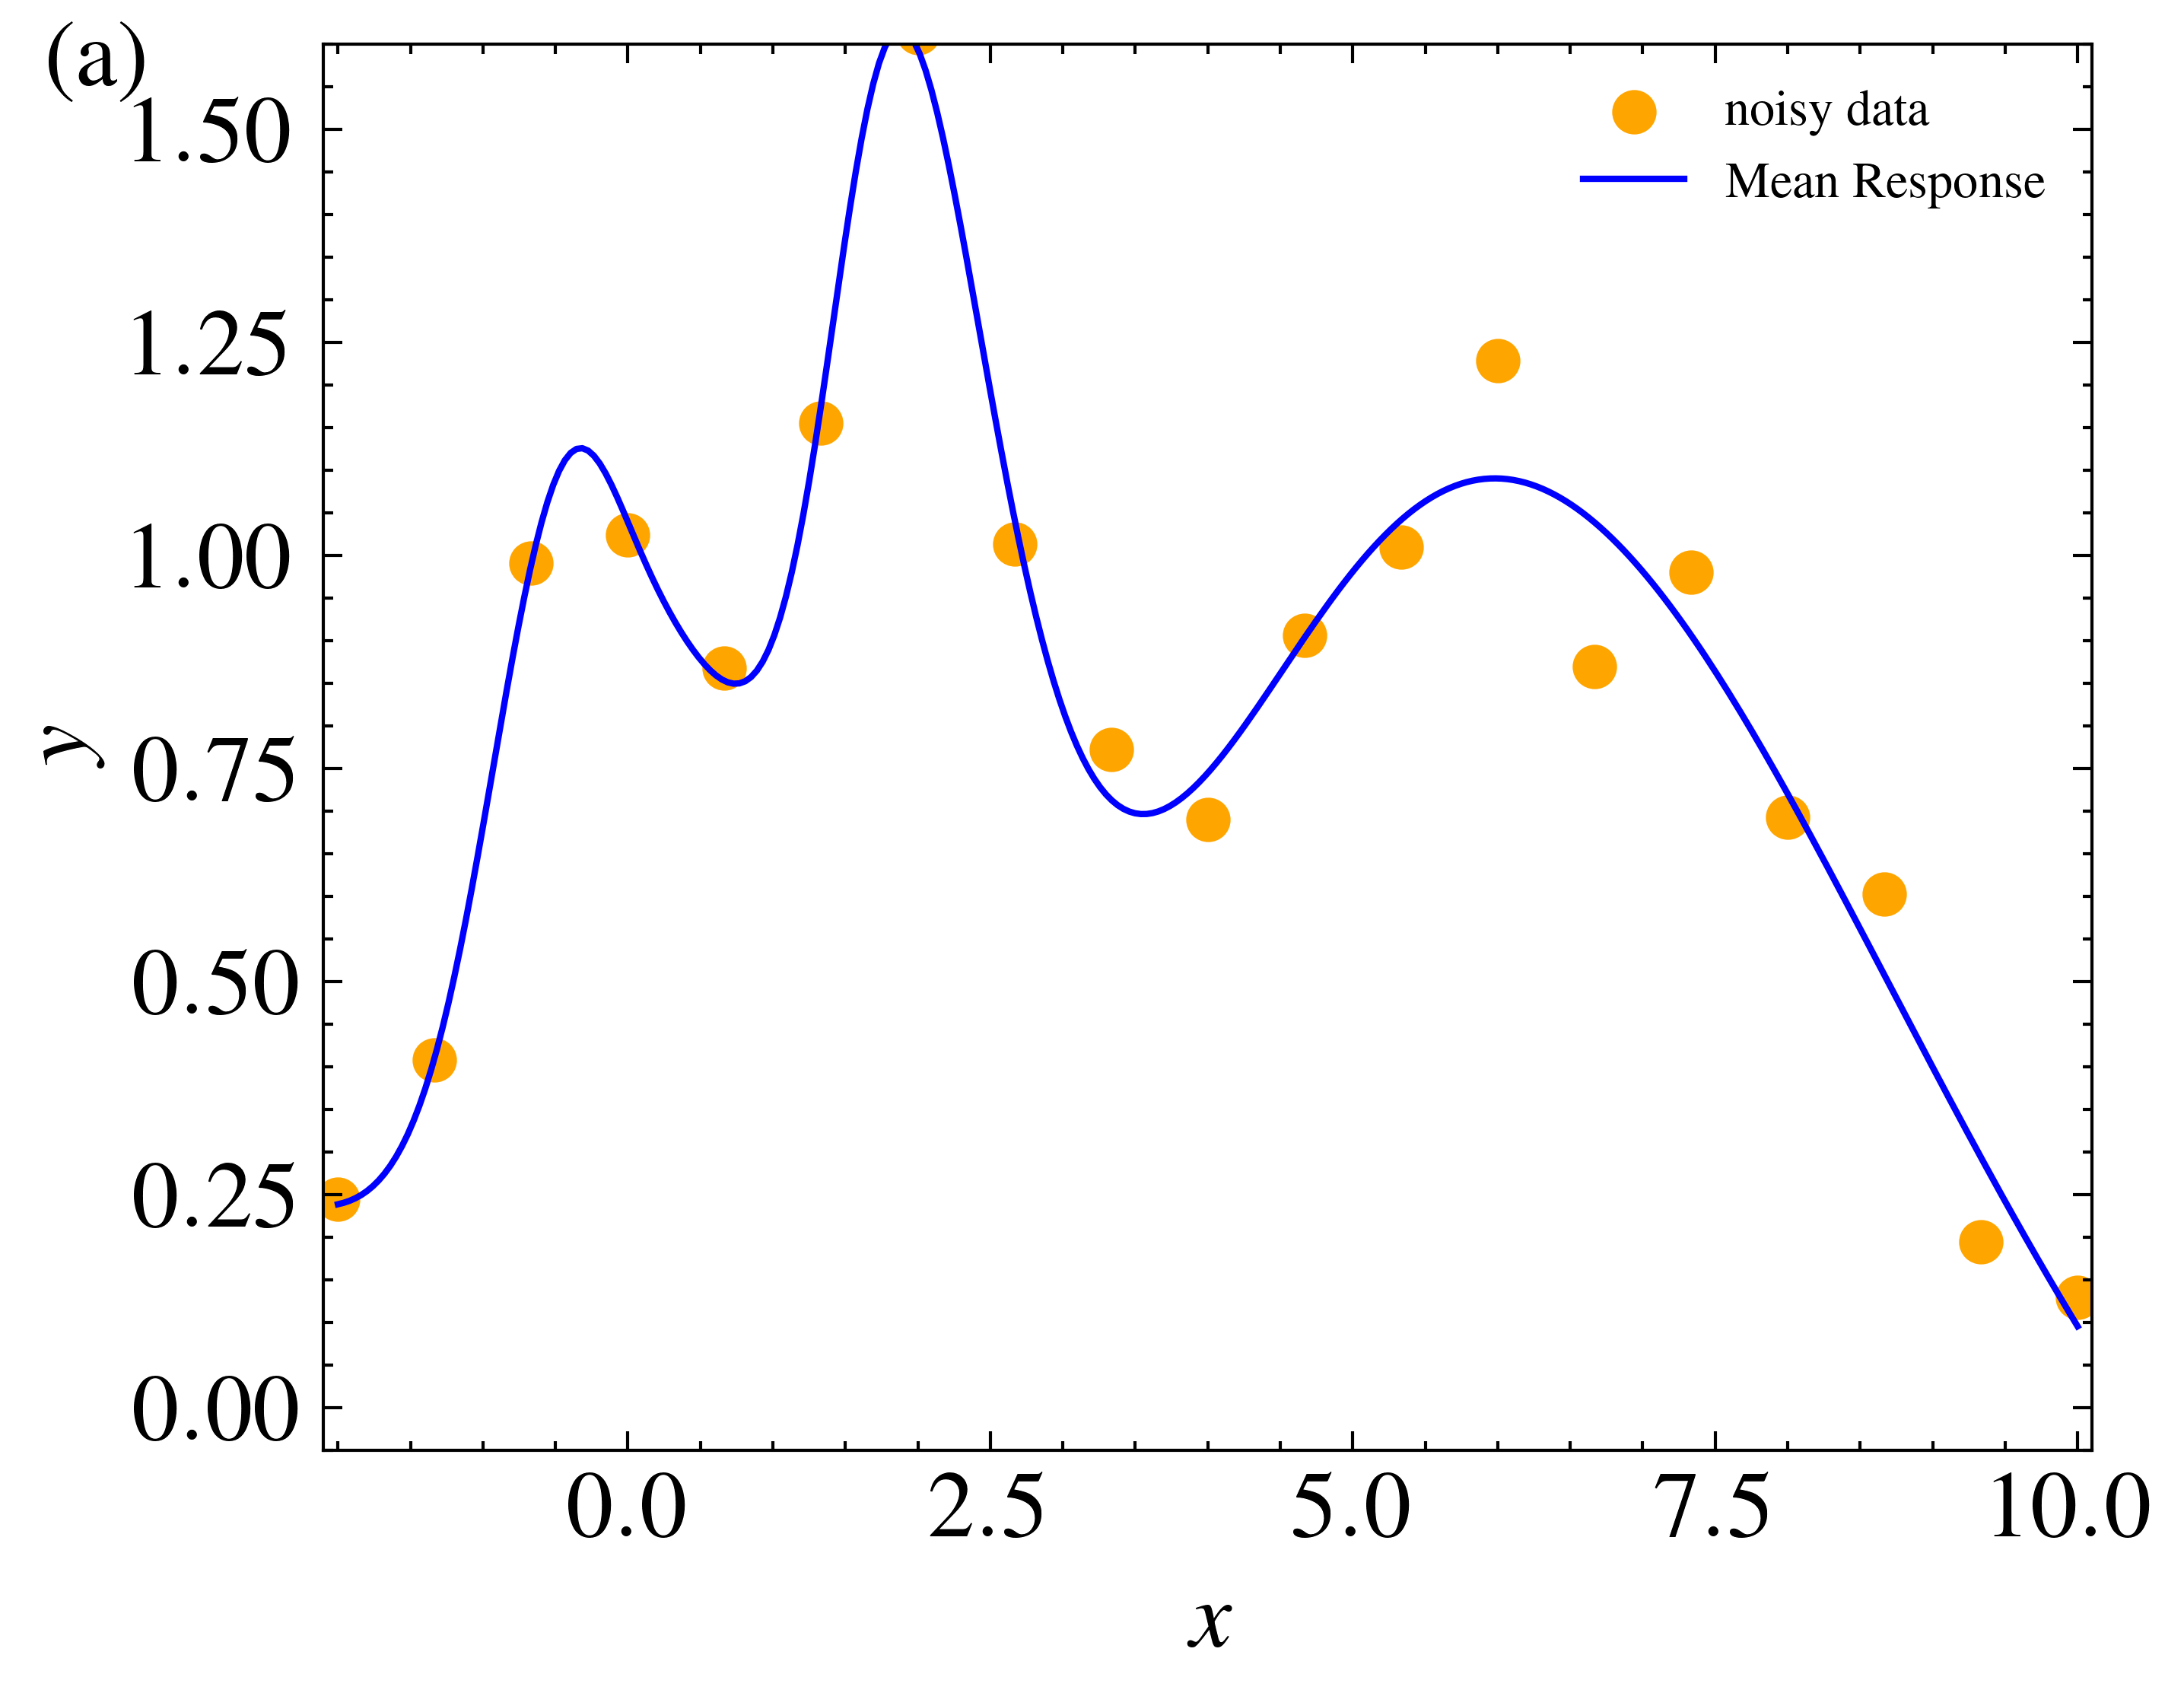

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True
# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data')

plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')


# Save output to CSV file
#output_data = np.hstack((inputx.data.numpy(), output.data.numpy()))
#np.savetxt('D:/PLA2024/outputsigmoidxnoise.csv', output_data, delimiter=',', header='x,output', comments='')
ax.text(-4, 1.55, '(a)',fontdict={'size': 15, 'color':  'black'})
# Save figure as EPS file
# Show plot
plt.legend()
# plt.savefig('D:/PLA2024/Fig2c.eps', format='eps')
plt.show()